In [1]:
# PACS details
domains = ['photo', 'art_painting', 'cartoon', 'sketch']
classes = ['dog', 'elephant', 'giraffe', 'guitar', 'horse','house', 'person']

In [2]:
!pip install scipy

# Set parameters

In [3]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.optim.swa_utils import AveragedModel, SWALR

import torchvision.datasets as Datasets
from torchvision import models
from torchvision.datasets import ImageFolder, DatasetFolder

from utils import *
import os

import numpy as np
import matplotlib.pyplot as plt

from model.resnet18_selfreg import resnet18


In [4]:
##############################
# Training Setting
##############################

# Select model to train
# resnet18(pytorch official):'resnet18_classic'
# SelfReg : 'resnet18' 
used_model = 'resnet18'
save_name = 'SelfReg_official_test_2'     # save_dir name
                                        # save_path : resnet_18/pacs/{save_name}/
dataset ='pacs'        
pacs_ver = '~/data/pacs_official_split' 
number_of_tests = 1
gpu_num = 1
n_workers = 6

##############################
# Basic Hyper-parameters
##############################

# is_selfreg = True  # use selfreg?
# is_idcl = True # use IDCL?
is_selfreg = True  # use selfreg?
is_idcl = True # use IDCL?

epochs = 30
batch_size = 128
is_pretrained = False  # Use ImageNet pretrain weight ?
used_optimizer = 'SGD' # 'Adam' or 'SGD'
is_hyp = True
#Learning rate
lr = 4e-3 
lr_decay_epoch = [100]
lr_decay_gamma = 0.1


train_tf, test_tf = get_tf(augment=True)


In [5]:
device = torch.device("cpu")
use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")
    device = torch.device("cuda:{}".format(gpu_num))
print(device)

# save settings
model_settings = {
    "used_model": used_model,
    "dataset": dataset,
    "save_name": save_name,
    "pacs_ver": pacs_ver,
    "number_of_tests": number_of_tests,
    "epochs": epochs,
    "batch_size": batch_size,
    "is_pretrained": is_pretrained,
    "lr": lr,
    "lr_decay_epoch": lr_decay_epoch,
    "lr_decay_gamma": lr_decay_gamma,
    "gpu_num": gpu_num,
    "is_hyp": True,
}

criterion = nn.CrossEntropyLoss().to(device)
#criterion = nn.NLLloss().to(device)

Using CUDA
cuda:1


# Functions

In [6]:

def classic_setting(
    test_domain_idx,
    domains,
    batch_size,
    is_pretrained,
    train_tf,
    test_tf,
    used_model,
    pacs_ver,
    used_optimizer,
    is_hyp,
):

    train_set1 = ImageFolder(
        root=os.path.join(
            "{}/train".format(pacs_ver), domains[(test_domain_idx + 1) % len(domains)]
        ),
        transform=train_tf,
    )
    train_set2 = ImageFolder(
        root=os.path.join(
            "{}/train".format(pacs_ver), domains[(test_domain_idx + 2) % len(domains)]
        ),
        transform=train_tf,
    )
    train_set3 = ImageFolder(
        root=os.path.join(
            "{}/train".format(pacs_ver), domains[(test_domain_idx + 3) % len(domains)]
        ),
        transform=train_tf,
    )

    val_set1 = ImageFolder(
        root=os.path.join(
            "{}/val".format(pacs_ver), domains[(test_domain_idx + 1) % len(domains)]
        ),
        transform=test_tf,
    )
    val_set2 = ImageFolder(
        root=os.path.join(
            "{}/val".format(pacs_ver), domains[(test_domain_idx + 2) % len(domains)]
        ),
        transform=test_tf,
    )
    val_set3 = ImageFolder(
        root=os.path.join(
            "{}/val".format(pacs_ver), domains[(test_domain_idx + 3) % len(domains)]
        ),
        transform=test_tf,
    )

    train_set = train_set1 + train_set2 + train_set3
    val_set = val_set1 + val_set2 + val_set3
    test_set = ImageFolder(
        root=os.path.join("{}/test".format(pacs_ver), domains[test_domain_idx]),
        transform=test_tf,
    )

    train_loader = DataLoader(
        train_set, batch_size=batch_size, shuffle=True, num_workers=n_workers
    )
    val_loader = DataLoader(
        val_set, batch_size=batch_size, shuffle=False, num_workers=n_workers
    )
    test_loader = DataLoader(
        test_set, batch_size=batch_size, shuffle=False, num_workers=n_workers
    )

    if used_model == "vgg16":
        model = models.vgg16(pretrained=is_pretrained).cuda()
        model.classifier[6].out_features = len(classes)
    elif used_model == "inceptionv3":
        model = models.inception_v3(pretrained=is_pretrained).cuda()
        model.AuxLogits.fc.out_features = len(classes)
        model.fc.out_features = len(classes)
    # 해당 코드 바꾸면 될듯? resnet18 부분..
    elif used_model == "resnet18":
        # load weights pretrained on ImageNet
        model = resnet18(pretrained=is_pretrained,is_hyp=is_hyp,c = 0.01, clip_r = 2)
        #num_ftrs = model.fc.in_features
        #model.fc = nn.Linear(num_ftrs, 7)
        model = model.to(device)
    elif used_model == "resnet18_classic":
        model = models.resnet18(pretrained=is_pretrained)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, len(classes))
        model = model.to(device)
    else:
        raise NotImplementedError

    if used_optimizer == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif used_optimizer == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    else:
        raise NotImplementedError

    swa_model = AveragedModel(model).to(device)
    swa_scr = SWALR(optimizer, swa_lr=0.004, anneal_epochs=1)
    scheduler = optim.lr_scheduler.MultiStepLR(
        optimizer, milestones=lr_decay_epoch, gamma=lr_decay_gamma
    )

    settings = {
        "train_loaders": train_loader,
        "val_loaders": val_loader,
        "optimizer": optimizer,
        "model": model,
        "lr_scheduler": scheduler,
        "swa_model": swa_model,
        "swa_scr": swa_scr,
    }

    return settings, test_loader


def IDCL_setting(
    test_domain_idx,
    domains,
    batch_size,
    is_pretrained,
    train_tf,
    test_tf,
    used_model,
    pacs_ver,
    used_optimizer,
    is_hyp,
):

    check = 1
    train_set = 0
    val_set = 0
    check_limit = 3

    for i in range(4):
        if check > check_limit:
            break
        if i == test_domain_idx:
            continue

        temp = ImageFolder(
            root=os.path.join("{}/train".format(pacs_ver), domains[i]),
            transform=train_tf,
        )

        temp_val = ImageFolder(
            root=os.path.join("{}/val".format(pacs_ver), domains[i]), transform=test_tf
        )
        if check == 1:
            train_set = temp
            val_set = temp_val
        else:
            train_set += temp
            val_set += temp_val

        if check == 1:
            train_set_stage1 = train_set
            val_set_stage1 = val_set
        elif check == 2:
            train_set_stage2 = train_set
            val_set_stage2 = val_set
        elif check == 3:
            train_set_stage3 = train_set
            val_set_stage3 = val_set

        check += 1

    test_set = ImageFolder(
        root=os.path.join("{}/test".format(pacs_ver), domains[test_domain_idx]),
        transform=test_tf,
    )

    print("stage1 (train,val):", len(train_set_stage1), len(val_set_stage1))
    print("stage2 (train,val):", len(train_set_stage2), len(val_set_stage2))
    print("stage3 (train,val):", len(train_set_stage3), len(val_set_stage3))
    print("test :", len(test_set))

    t_loader1 = DataLoader(
        train_set_stage1, batch_size=batch_size, shuffle=True, num_workers=6
    )
    v_loader1 = DataLoader(
        val_set_stage1, batch_size=batch_size, shuffle=True, num_workers=6
    )

    t_loader2 = DataLoader(
        train_set_stage2, batch_size=batch_size, shuffle=True, num_workers=6
    )
    v_loader2 = DataLoader(
        val_set_stage2, batch_size=batch_size, shuffle=True, num_workers=6
    )

    t_loader3 = DataLoader(
        train_set_stage3, batch_size=batch_size, shuffle=True, num_workers=6
    )
    v_loader3 = DataLoader(
        val_set_stage3, batch_size=batch_size, shuffle=True, num_workers=6
    )

    test_loader = DataLoader(
        test_set, batch_size=batch_size, shuffle=False, num_workers=6
    )

    if used_model == "vgg16":
        print("vgg16")
        model = models.vgg16(pretrained=is_pretrained).cuda()
        model.classifier[6].out_features = 7
    elif used_model == "inceptionv3":
        model = models.inception_v3(pretrained=is_pretrained).cuda()
        model.AuxLogits.fc.out_features = 7
        model.fc.out_features = 7
    elif used_model == "resnet18":
        model = resnet18(pretrained=is_pretrained,is_hyp=is_hyp,c = 0.01, clip_r = 2)
        #num_ftrs = model.fc.in_features
        #model.fc = nn.Linear(num_ftrs, 7)
        model = model.to(device)
    elif used_model == "resnet18_classic":
        model = models.resnet18(pretrained=is_pretrained)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 7)
        model = model.to(device)
    else:
        raise NotImplementedError

    if used_optimizer == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif used_optimizer == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    else:
        raise NotImplementedError

    swa_model = AveragedModel(model).to(device)
    swa_scr = SWALR(optimizer, swa_lr=0.004, anneal_epochs=1)
    scheduler = optim.lr_scheduler.MultiStepLR(
        optimizer, milestones=lr_decay_epoch, gamma=lr_decay_gamma
    )

    train_loaders = [t_loader1, t_loader2, t_loader3]
    val_loaders = [v_loader1, v_loader2, v_loader3]

    settings = {
        "train_loaders": train_loaders,
        "val_loaders": val_loaders,
        "optimizer": optimizer,
        "model": model,
        "lr_scheduler": scheduler,
        "swa_model": swa_model,
        "swa_scr": swa_scr,
    }

    return settings, test_loader



In [7]:
##############################
# Training Setting
##############################

# Select model to train
# resnet18(pytorch official):'resnet18_classic'
# SelfReg : 'resnet18' 
used_model = 'resnet18'
save_name = 'SelfReg_official_test_HYPTEST'     # save_dir name
                                        # save_path : resnet_18/pacs/{save_name}/
dataset ='pacs'        
pacs_ver = '~/data/pacs_official_split' 
number_of_tests = 5
gpu_num = 1
n_workers = 6

##############################
# Basic Hyper-parameters
##############################

# is_selfreg = True  # use selfreg?
# is_idcl = True # use IDCL?
is_selfreg = True  # use selfreg?
is_idcl = False # use IDCL?

epochs = 120
batch_size = 128
is_pretrained = False  # Use ImageNet pretrain weight ?
used_optimizer = 'SGD' # 'Adam' or 'SGD'
is_hyp = True
#Learning rate
lr = 4e-3 
lr_decay_epoch = [100]
lr_decay_gamma = 0.1


train_tf, test_tf = get_tf(augment=True)



# Automation

save_dir resnet18/pacs/SelfReg_official_test_HYPTEST/photo+art_painting+cartoon(sketch)/
device cuda:1
epoch: 0
Validation ==================================================
Avg acc (val): 0.2305
epoch: 1
Validation ==================================================
Avg acc (val): 0.2321
epoch: 2
Validation ==================================================
Avg acc (val): 0.2630
epoch: 3
Validation ==================================================
Avg acc (val): 0.2597
epoch: 4
Validation ==================================================
Avg acc (val): 0.2386
epoch: 5
Validation ==================================================
Avg acc (val): 0.3247
epoch: 6
Validation ==================================================
Avg acc (val): 0.3101
epoch: 7
Validation ==================================================
Avg acc (val): 0.3474
epoch: 8
Validation ==================================================
Avg acc (val): 0.3231
epoch: 9
Validation ========================================

epoch: 87
Validation ==================================================
Avg acc (val): 0.6510
epoch: 88
Validation ==================================================
Avg acc (val): 0.7045
epoch: 89
Validation ==================================================
Avg acc (val): 0.6623
epoch: 90
Validation ==================================================
Avg acc (val): 0.7029
epoch: 91
Validation ==================================================
Avg acc (val): 0.6234
epoch: 92
Validation ==================================================
Avg acc (val): 0.6558
epoch: 93
Validation ==================================================
Avg acc (val): 0.6851
epoch: 94
Validation ==================================================
Avg acc (val): 0.6769
epoch: 95
Validation ==================================================
Avg acc (val): 0.7029
epoch: 96
Validation ==================================================
Avg acc (val): 0.6331
epoch: 97
Validation =======================================

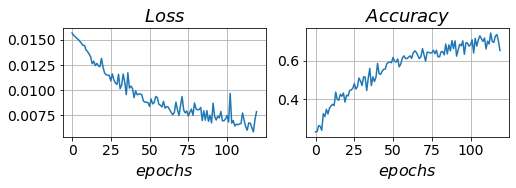

save_dir resnet18/pacs/SelfReg_official_test_HYPTEST/photo+art_painting+sketch(cartoon)/
device cuda:1
epoch: 0
Validation ==================================================
Avg acc (val): 0.2188
epoch: 1
Validation ==================================================
Avg acc (val): 0.2510
epoch: 2
Validation ==================================================
Avg acc (val): 0.2214
epoch: 3
Validation ==================================================
Avg acc (val): 0.2921
epoch: 4
Validation ==================================================
Avg acc (val): 0.2844
epoch: 5
Validation ==================================================
Avg acc (val): 0.2728
epoch: 6
Validation ==================================================
Avg acc (val): 0.3385
epoch: 7
Validation ==================================================
Avg acc (val): 0.3668
epoch: 8
Validation ==================================================
Avg acc (val): 0.3411
epoch: 9
Validation ========================================

epoch: 87
Validation ==================================================
Avg acc (val): 0.6963
epoch: 88
Validation ==================================================
Avg acc (val): 0.7259
epoch: 89
Validation ==================================================
Avg acc (val): 0.7477
epoch: 90
Validation ==================================================
Avg acc (val): 0.7632
epoch: 91
Validation ==================================================
Avg acc (val): 0.7413
epoch: 92
Validation ==================================================
Avg acc (val): 0.6885
epoch: 93
Validation ==================================================
Avg acc (val): 0.7580
epoch: 94
Validation ==================================================
Avg acc (val): 0.7516
epoch: 95
Validation ==================================================
Avg acc (val): 0.7503
epoch: 96
Validation ==================================================
Avg acc (val): 0.7490
epoch: 97
Validation =======================================

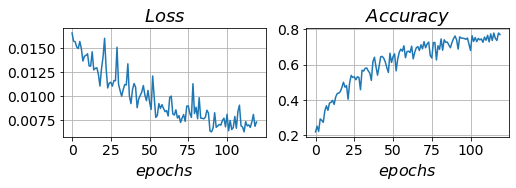

save_dir resnet18/pacs/SelfReg_official_test_HYPTEST/photo+cartoon+sketch(art_painting)/
device cuda:1
epoch: 0
Validation ==================================================
Avg acc (val): 0.1824
epoch: 1
Validation ==================================================
Avg acc (val): 0.2345
epoch: 2
Validation ==================================================
Avg acc (val): 0.3040
epoch: 3
Validation ==================================================
Avg acc (val): 0.3139
epoch: 4
Validation ==================================================
Avg acc (val): 0.2184
epoch: 5
Validation ==================================================
Avg acc (val): 0.3400
epoch: 6
Validation ==================================================
Avg acc (val): 0.3201
epoch: 7
Validation ==================================================
Avg acc (val): 0.3586
epoch: 8
Validation ==================================================
Avg acc (val): 0.3052
epoch: 9
Validation ========================================

epoch: 87
Validation ==================================================
Avg acc (val): 0.7047
epoch: 88
Validation ==================================================
Avg acc (val): 0.7283
epoch: 89
Validation ==================================================
Avg acc (val): 0.7630
epoch: 90
Validation ==================================================
Avg acc (val): 0.7866
epoch: 91
Validation ==================================================
Avg acc (val): 0.7854
epoch: 92
Validation ==================================================
Avg acc (val): 0.7643
epoch: 93
Validation ==================================================
Avg acc (val): 0.7891
epoch: 94
Validation ==================================================
Avg acc (val): 0.7519
epoch: 95
Validation ==================================================
Avg acc (val): 0.8065
epoch: 96
Validation ==================================================
Avg acc (val): 0.7705
epoch: 97
Validation =======================================

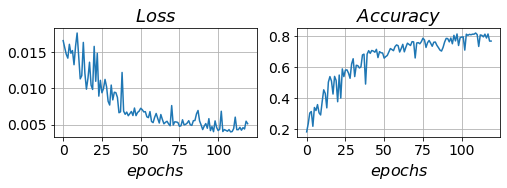

save_dir resnet18/pacs/SelfReg_official_test_HYPTEST/art_painting+cartoon+sketch(photo)/
device cuda:1
epoch: 0
Validation ==================================================
Avg acc (val): 0.1993
epoch: 1
Validation ==================================================
Avg acc (val): 0.3203
epoch: 2
Validation ==================================================
Avg acc (val): 0.2942
epoch: 3
Validation ==================================================
Avg acc (val): 0.2562
epoch: 4
Validation ==================================================
Avg acc (val): 0.2954
epoch: 5
Validation ==================================================
Avg acc (val): 0.2693
epoch: 6
Validation ==================================================
Avg acc (val): 0.2574
epoch: 7
Validation ==================================================
Avg acc (val): 0.3713
epoch: 8
Validation ==================================================
Avg acc (val): 0.3796
epoch: 9
Validation ========================================

epoch: 87
Validation ==================================================
Avg acc (val): 0.7236
epoch: 88
Validation ==================================================
Avg acc (val): 0.7153
epoch: 89
Validation ==================================================
Avg acc (val): 0.7248
epoch: 90
Validation ==================================================
Avg acc (val): 0.7094
epoch: 91
Validation ==================================================
Avg acc (val): 0.7295
epoch: 92
Validation ==================================================
Avg acc (val): 0.7236
epoch: 93
Validation ==================================================
Avg acc (val): 0.6963
epoch: 94
Validation ==================================================
Avg acc (val): 0.7402
epoch: 95
Validation ==================================================
Avg acc (val): 0.7248
epoch: 96
Validation ==================================================
Avg acc (val): 0.7284
epoch: 97
Validation =======================================

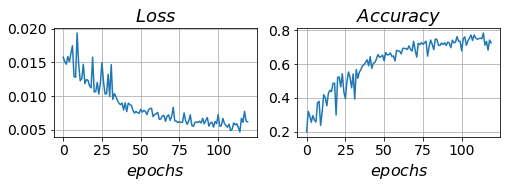

save_dir resnet18/pacs/SelfReg_official_test_HYPTEST/photo+art_painting+cartoon(sketch)/
device cuda:1
epoch: 0
Validation ==================================================
Avg acc (val): 0.2094
epoch: 1
Validation ==================================================
Avg acc (val): 0.2532
epoch: 2
Validation ==================================================
Avg acc (val): 0.2500
epoch: 3
Validation ==================================================
Avg acc (val): 0.3084
epoch: 4
Validation ==================================================
Avg acc (val): 0.2256
epoch: 5
Validation ==================================================
Avg acc (val): 0.3231
epoch: 6
Validation ==================================================
Avg acc (val): 0.3231
epoch: 7
Validation ==================================================
Avg acc (val): 0.3636
epoch: 8
Validation ==================================================
Avg acc (val): 0.3782
epoch: 9
Validation ========================================

epoch: 87
Validation ==================================================
Avg acc (val): 0.6510
epoch: 88
Validation ==================================================
Avg acc (val): 0.6526
epoch: 89
Validation ==================================================
Avg acc (val): 0.6705
epoch: 90
Validation ==================================================
Avg acc (val): 0.6899
epoch: 91
Validation ==================================================
Avg acc (val): 0.6997
epoch: 92
Validation ==================================================
Avg acc (val): 0.6526
epoch: 93
Validation ==================================================
Avg acc (val): 0.6916
epoch: 94
Validation ==================================================
Avg acc (val): 0.6104
epoch: 95
Validation ==================================================
Avg acc (val): 0.6899
epoch: 96
Validation ==================================================
Avg acc (val): 0.6721
epoch: 97
Validation =======================================

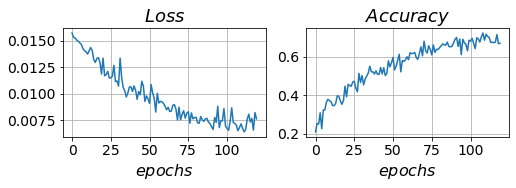

save_dir resnet18/pacs/SelfReg_official_test_HYPTEST/photo+art_painting+sketch(cartoon)/
device cuda:1
epoch: 0
Validation ==================================================
Avg acc (val): 0.2227
epoch: 1
Validation ==================================================
Avg acc (val): 0.2342
epoch: 2
Validation ==================================================
Avg acc (val): 0.2806
epoch: 3
Validation ==================================================
Avg acc (val): 0.3501
epoch: 4
Validation ==================================================
Avg acc (val): 0.2394
epoch: 5
Validation ==================================================
Avg acc (val): 0.3719
epoch: 6
Validation ==================================================
Avg acc (val): 0.3436
epoch: 7
Validation ==================================================
Avg acc (val): 0.3771
epoch: 8
Validation ==================================================
Avg acc (val): 0.3591
epoch: 9
Validation ========================================

epoch: 87
Validation ==================================================
Avg acc (val): 0.7375
epoch: 88
Validation ==================================================
Avg acc (val): 0.7310
epoch: 89
Validation ==================================================
Avg acc (val): 0.6834
epoch: 90
Validation ==================================================
Avg acc (val): 0.7387
epoch: 91
Validation ==================================================
Avg acc (val): 0.7413
epoch: 92
Validation ==================================================
Avg acc (val): 0.7169
epoch: 93
Validation ==================================================
Avg acc (val): 0.7761
epoch: 94
Validation ==================================================
Avg acc (val): 0.7272
epoch: 95
Validation ==================================================
Avg acc (val): 0.7207
epoch: 96
Validation ==================================================
Avg acc (val): 0.7079
epoch: 97
Validation =======================================

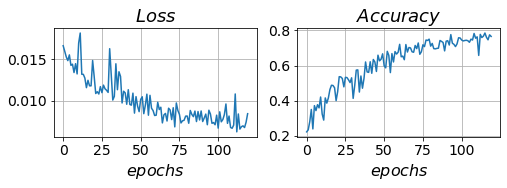

save_dir resnet18/pacs/SelfReg_official_test_HYPTEST/photo+cartoon+sketch(art_painting)/
device cuda:1
epoch: 0
Validation ==================================================
Avg acc (val): 0.1935
epoch: 1
Validation ==================================================
Avg acc (val): 0.2643
epoch: 2
Validation ==================================================
Avg acc (val): 0.2457
epoch: 3
Validation ==================================================
Avg acc (val): 0.3424
epoch: 4
Validation ==================================================
Avg acc (val): 0.3648
epoch: 5
Validation ==================================================
Avg acc (val): 0.2531
epoch: 6
Validation ==================================================
Avg acc (val): 0.3499
epoch: 7
Validation ==================================================
Avg acc (val): 0.4342
epoch: 8
Validation ==================================================
Avg acc (val): 0.4342
epoch: 9
Validation ========================================

epoch: 87
Validation ==================================================
Avg acc (val): 0.7953
epoch: 88
Validation ==================================================
Avg acc (val): 0.7655
epoch: 89
Validation ==================================================
Avg acc (val): 0.7692
epoch: 90
Validation ==================================================
Avg acc (val): 0.7866
epoch: 91
Validation ==================================================
Avg acc (val): 0.7667
epoch: 92
Validation ==================================================
Avg acc (val): 0.7854
epoch: 93
Validation ==================================================
Avg acc (val): 0.7531
epoch: 94
Validation ==================================================
Avg acc (val): 0.7792
epoch: 95
Validation ==================================================
Avg acc (val): 0.7593
epoch: 96
Validation ==================================================
Avg acc (val): 0.8027
epoch: 97
Validation =======================================

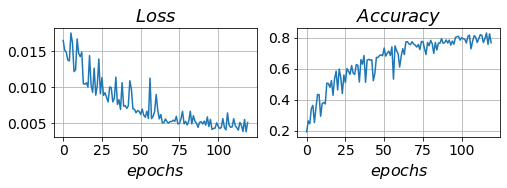

save_dir resnet18/pacs/SelfReg_official_test_HYPTEST/art_painting+cartoon+sketch(photo)/
device cuda:1
epoch: 0
Validation ==================================================
Avg acc (val): 0.2135
epoch: 1
Validation ==================================================
Avg acc (val): 0.2005
epoch: 2
Validation ==================================================
Avg acc (val): 0.2894
epoch: 3
Validation ==================================================
Avg acc (val): 0.2550
epoch: 4
Validation ==================================================
Avg acc (val): 0.2266
epoch: 5
Validation ==================================================
Avg acc (val): 0.3737
epoch: 6
Validation ==================================================
Avg acc (val): 0.3535
epoch: 7
Validation ==================================================
Avg acc (val): 0.2444
epoch: 8
Validation ==================================================
Avg acc (val): 0.3262
epoch: 9
Validation ========================================

epoch: 87
Validation ==================================================
Avg acc (val): 0.6714
epoch: 88
Validation ==================================================
Avg acc (val): 0.7461
epoch: 89
Validation ==================================================
Avg acc (val): 0.7165
epoch: 90
Validation ==================================================
Avg acc (val): 0.7592
epoch: 91
Validation ==================================================
Avg acc (val): 0.7521
epoch: 92
Validation ==================================================
Avg acc (val): 0.7497
epoch: 93
Validation ==================================================
Avg acc (val): 0.7272
epoch: 94
Validation ==================================================
Avg acc (val): 0.7189
epoch: 95
Validation ==================================================
Avg acc (val): 0.7592
epoch: 96
Validation ==================================================
Avg acc (val): 0.6951
epoch: 97
Validation =======================================

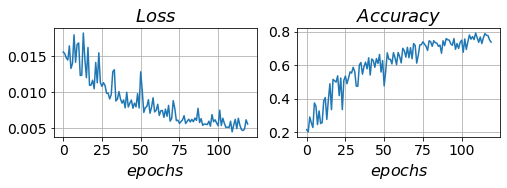

save_dir resnet18/pacs/SelfReg_official_test_HYPTEST/photo+art_painting+cartoon(sketch)/
device cuda:1
epoch: 0
Validation ==================================================
Avg acc (val): 0.1997
epoch: 1
Validation ==================================================
Avg acc (val): 0.2695
epoch: 2
Validation ==================================================
Avg acc (val): 0.2516
epoch: 3
Validation ==================================================
Avg acc (val): 0.2435
epoch: 4
Validation ==================================================
Avg acc (val): 0.2760
epoch: 5
Validation ==================================================
Avg acc (val): 0.3198
epoch: 6
Validation ==================================================
Avg acc (val): 0.3506
epoch: 7
Validation ==================================================
Avg acc (val): 0.3312
epoch: 8
Validation ==================================================
Avg acc (val): 0.3279
epoch: 9
Validation ========================================

epoch: 87
Validation ==================================================
Avg acc (val): 0.6948
epoch: 88
Validation ==================================================
Avg acc (val): 0.7062
epoch: 89
Validation ==================================================
Avg acc (val): 0.6818
epoch: 90
Validation ==================================================
Avg acc (val): 0.6039
epoch: 91
Validation ==================================================
Avg acc (val): 0.6607
epoch: 92
Validation ==================================================
Avg acc (val): 0.6786
epoch: 93
Validation ==================================================
Avg acc (val): 0.6234
epoch: 94
Validation ==================================================
Avg acc (val): 0.6558
epoch: 95
Validation ==================================================
Avg acc (val): 0.7013
epoch: 96
Validation ==================================================
Avg acc (val): 0.6721
epoch: 97
Validation =======================================

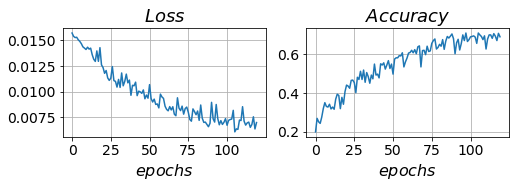

save_dir resnet18/pacs/SelfReg_official_test_HYPTEST/photo+art_painting+sketch(cartoon)/
device cuda:1
epoch: 0
Validation ==================================================
Avg acc (val): 0.1802
epoch: 1
Validation ==================================================
Avg acc (val): 0.3063
epoch: 2
Validation ==================================================
Avg acc (val): 0.3050
epoch: 3
Validation ==================================================
Avg acc (val): 0.2780
epoch: 4
Validation ==================================================
Avg acc (val): 0.3372
epoch: 5
Validation ==================================================
Avg acc (val): 0.3179
epoch: 6
Validation ==================================================
Avg acc (val): 0.3333
epoch: 7
Validation ==================================================
Avg acc (val): 0.4028
epoch: 8
Validation ==================================================
Avg acc (val): 0.4003
epoch: 9
Validation ========================================

epoch: 87
Validation ==================================================
Avg acc (val): 0.7066
epoch: 88
Validation ==================================================
Avg acc (val): 0.7130
epoch: 89
Validation ==================================================
Avg acc (val): 0.7181
epoch: 90
Validation ==================================================
Avg acc (val): 0.7400
epoch: 91
Validation ==================================================
Avg acc (val): 0.7297
epoch: 92
Validation ==================================================
Avg acc (val): 0.7246
epoch: 93
Validation ==================================================
Avg acc (val): 0.7542
epoch: 94
Validation ==================================================
Avg acc (val): 0.7143
epoch: 95
Validation ==================================================
Avg acc (val): 0.7375
epoch: 96
Validation ==================================================
Avg acc (val): 0.7426
epoch: 97
Validation =======================================

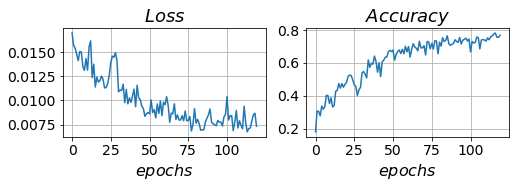

save_dir resnet18/pacs/SelfReg_official_test_HYPTEST/photo+cartoon+sketch(art_painting)/
device cuda:1
epoch: 0
Validation ==================================================
Avg acc (val): 0.2469
epoch: 1
Validation ==================================================
Avg acc (val): 0.2605
epoch: 2
Validation ==================================================
Avg acc (val): 0.2928
epoch: 3
Validation ==================================================
Avg acc (val): 0.2605
epoch: 4
Validation ==================================================
Avg acc (val): 0.3040
epoch: 5
Validation ==================================================
Avg acc (val): 0.3065
epoch: 6
Validation ==================================================
Avg acc (val): 0.3350
epoch: 7
Validation ==================================================
Avg acc (val): 0.3536
epoch: 8
Validation ==================================================
Avg acc (val): 0.2655
epoch: 9
Validation ========================================

epoch: 87
Validation ==================================================
Avg acc (val): 0.7792
epoch: 88
Validation ==================================================
Avg acc (val): 0.7556
epoch: 89
Validation ==================================================
Avg acc (val): 0.7370
epoch: 90
Validation ==================================================
Avg acc (val): 0.7308
epoch: 91
Validation ==================================================
Avg acc (val): 0.7407
epoch: 92
Validation ==================================================
Avg acc (val): 0.7605
epoch: 93
Validation ==================================================
Avg acc (val): 0.7109
epoch: 94
Validation ==================================================
Avg acc (val): 0.7320
epoch: 95
Validation ==================================================
Avg acc (val): 0.7270
epoch: 96
Validation ==================================================
Avg acc (val): 0.7717
epoch: 97
Validation =======================================

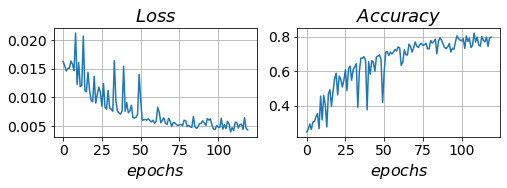

save_dir resnet18/pacs/SelfReg_official_test_HYPTEST/art_painting+cartoon+sketch(photo)/
device cuda:1
epoch: 0
Validation ==================================================
Avg acc (val): 0.1957
epoch: 1
Validation ==================================================
Avg acc (val): 0.2586
epoch: 2
Validation ==================================================
Avg acc (val): 0.2954
epoch: 3
Validation ==================================================
Avg acc (val): 0.3286
epoch: 4
Validation ==================================================
Avg acc (val): 0.3393
epoch: 5
Validation ==================================================
Avg acc (val): 0.2716
epoch: 6
Validation ==================================================
Avg acc (val): 0.3677
epoch: 7
Validation ==================================================
Avg acc (val): 0.2467
epoch: 8
Validation ==================================================
Avg acc (val): 0.2349
epoch: 9
Validation ========================================

epoch: 87
Validation ==================================================
Avg acc (val): 0.6928
epoch: 88
Validation ==================================================
Avg acc (val): 0.7331
epoch: 89
Validation ==================================================
Avg acc (val): 0.7390
epoch: 90
Validation ==================================================
Avg acc (val): 0.7165
epoch: 91
Validation ==================================================
Avg acc (val): 0.7106
epoch: 92
Validation ==================================================
Avg acc (val): 0.6845
epoch: 93
Validation ==================================================
Avg acc (val): 0.6833
epoch: 94
Validation ==================================================
Avg acc (val): 0.7544
epoch: 95
Validation ==================================================
Avg acc (val): 0.7200
epoch: 96
Validation ==================================================
Avg acc (val): 0.6880
epoch: 97
Validation =======================================

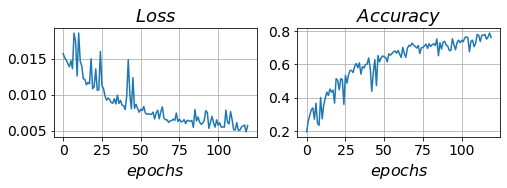

save_dir resnet18/pacs/SelfReg_official_test_HYPTEST/photo+art_painting+cartoon(sketch)/
device cuda:1
epoch: 0
Validation ==================================================
Avg acc (val): 0.2110
epoch: 1
Validation ==================================================
Avg acc (val): 0.2614
epoch: 2
Validation ==================================================
Avg acc (val): 0.2386
epoch: 3
Validation ==================================================
Avg acc (val): 0.2614
epoch: 4
Validation ==================================================
Avg acc (val): 0.2825
epoch: 5
Validation ==================================================
Avg acc (val): 0.3474
epoch: 6
Validation ==================================================
Avg acc (val): 0.3393
epoch: 7
Validation ==================================================
Avg acc (val): 0.3393
epoch: 8
Validation ==================================================
Avg acc (val): 0.3442
epoch: 9
Validation ========================================

epoch: 87
Validation ==================================================
Avg acc (val): 0.6347
epoch: 88
Validation ==================================================
Avg acc (val): 0.7045
epoch: 89
Validation ==================================================
Avg acc (val): 0.6672
epoch: 90
Validation ==================================================
Avg acc (val): 0.6737
epoch: 91
Validation ==================================================
Avg acc (val): 0.6769
epoch: 92
Validation ==================================================
Avg acc (val): 0.6510
epoch: 93
Validation ==================================================
Avg acc (val): 0.6981
epoch: 94
Validation ==================================================
Avg acc (val): 0.6607
epoch: 95
Validation ==================================================
Avg acc (val): 0.6672
epoch: 96
Validation ==================================================
Avg acc (val): 0.6494
epoch: 97
Validation =======================================

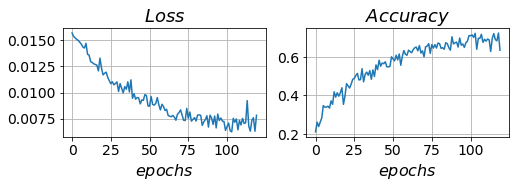

save_dir resnet18/pacs/SelfReg_official_test_HYPTEST/photo+art_painting+sketch(cartoon)/
device cuda:1
epoch: 0
Validation ==================================================
Avg acc (val): 0.2175
epoch: 1
Validation ==================================================
Avg acc (val): 0.2561
epoch: 2
Validation ==================================================
Avg acc (val): 0.3127
epoch: 3
Validation ==================================================
Avg acc (val): 0.3771
epoch: 4
Validation ==================================================
Avg acc (val): 0.3578
epoch: 5
Validation ==================================================
Avg acc (val): 0.4247
epoch: 6
Validation ==================================================
Avg acc (val): 0.3655
epoch: 7
Validation ==================================================
Avg acc (val): 0.3694
epoch: 8
Validation ==================================================
Avg acc (val): 0.3694
epoch: 9
Validation ========================================

epoch: 87
Validation ==================================================
Avg acc (val): 0.7503
epoch: 88
Validation ==================================================
Avg acc (val): 0.7542
epoch: 89
Validation ==================================================
Avg acc (val): 0.7593
epoch: 90
Validation ==================================================
Avg acc (val): 0.7465
epoch: 91
Validation ==================================================
Avg acc (val): 0.7465
epoch: 92
Validation ==================================================
Avg acc (val): 0.7362
epoch: 93
Validation ==================================================
Avg acc (val): 0.7040
epoch: 94
Validation ==================================================
Avg acc (val): 0.7619
epoch: 95
Validation ==================================================
Avg acc (val): 0.7568
epoch: 96
Validation ==================================================
Avg acc (val): 0.7452
epoch: 97
Validation =======================================

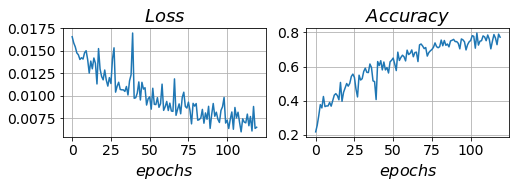

save_dir resnet18/pacs/SelfReg_official_test_HYPTEST/photo+cartoon+sketch(art_painting)/
device cuda:1
epoch: 0
Validation ==================================================
Avg acc (val): 0.2395
epoch: 1
Validation ==================================================
Avg acc (val): 0.2469
epoch: 2
Validation ==================================================
Avg acc (val): 0.2779
epoch: 3
Validation ==================================================
Avg acc (val): 0.3027
epoch: 4
Validation ==================================================
Avg acc (val): 0.2432
epoch: 5
Validation ==================================================
Avg acc (val): 0.3896
epoch: 6
Validation ==================================================
Avg acc (val): 0.2593
epoch: 7
Validation ==================================================
Avg acc (val): 0.2891
epoch: 8
Validation ==================================================
Avg acc (val): 0.2866
epoch: 9
Validation ========================================

epoch: 87
Validation ==================================================
Avg acc (val): 0.7816
epoch: 88
Validation ==================================================
Avg acc (val): 0.7432
epoch: 89
Validation ==================================================
Avg acc (val): 0.7730
epoch: 90
Validation ==================================================
Avg acc (val): 0.7581
epoch: 91
Validation ==================================================
Avg acc (val): 0.7432
epoch: 92
Validation ==================================================
Avg acc (val): 0.7903
epoch: 93
Validation ==================================================
Avg acc (val): 0.8040
epoch: 94
Validation ==================================================
Avg acc (val): 0.7978
epoch: 95
Validation ==================================================
Avg acc (val): 0.7854
epoch: 96
Validation ==================================================
Avg acc (val): 0.7357
epoch: 97
Validation =======================================

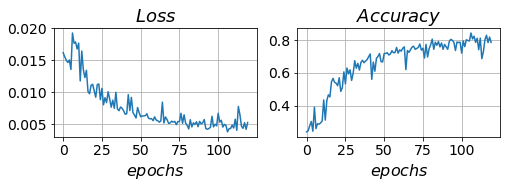

save_dir resnet18/pacs/SelfReg_official_test_HYPTEST/art_painting+cartoon+sketch(photo)/
device cuda:1
epoch: 0
Validation ==================================================
Avg acc (val): 0.2017
epoch: 1
Validation ==================================================
Avg acc (val): 0.2064
epoch: 2
Validation ==================================================
Avg acc (val): 0.2693
epoch: 3
Validation ==================================================
Avg acc (val): 0.3167
epoch: 4
Validation ==================================================
Avg acc (val): 0.3630
epoch: 5
Validation ==================================================
Avg acc (val): 0.1969
epoch: 6
Validation ==================================================
Avg acc (val): 0.2539
epoch: 7
Validation ==================================================
Avg acc (val): 0.2420
epoch: 8
Validation ==================================================
Avg acc (val): 0.3713
epoch: 9
Validation ========================================

epoch: 87
Validation ==================================================
Avg acc (val): 0.7272
epoch: 88
Validation ==================================================
Avg acc (val): 0.7556
epoch: 89
Validation ==================================================
Avg acc (val): 0.7106
epoch: 90
Validation ==================================================
Avg acc (val): 0.7355
epoch: 91
Validation ==================================================
Avg acc (val): 0.7295
epoch: 92
Validation ==================================================
Avg acc (val): 0.7284
epoch: 93
Validation ==================================================
Avg acc (val): 0.7212
epoch: 94
Validation ==================================================
Avg acc (val): 0.7592
epoch: 95
Validation ==================================================
Avg acc (val): 0.7651
epoch: 96
Validation ==================================================
Avg acc (val): 0.7224
epoch: 97
Validation =======================================

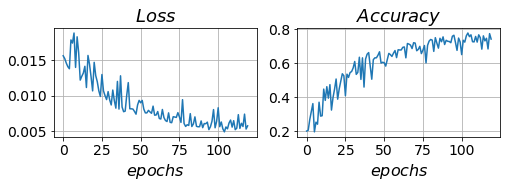

save_dir resnet18/pacs/SelfReg_official_test_HYPTEST/photo+art_painting+cartoon(sketch)/
device cuda:1
epoch: 0
Validation ==================================================
Avg acc (val): 0.2110
epoch: 1
Validation ==================================================
Avg acc (val): 0.2565
epoch: 2
Validation ==================================================
Avg acc (val): 0.2922
epoch: 3
Validation ==================================================
Avg acc (val): 0.2890
epoch: 4
Validation ==================================================
Avg acc (val): 0.3198
epoch: 5
Validation ==================================================
Avg acc (val): 0.3166
epoch: 6
Validation ==================================================
Avg acc (val): 0.3166
epoch: 7
Validation ==================================================
Avg acc (val): 0.3523
epoch: 8
Validation ==================================================
Avg acc (val): 0.3701
epoch: 9
Validation ========================================

epoch: 87
Validation ==================================================
Avg acc (val): 0.6656
epoch: 88
Validation ==================================================
Avg acc (val): 0.7062
epoch: 89
Validation ==================================================
Avg acc (val): 0.6347
epoch: 90
Validation ==================================================
Avg acc (val): 0.6640
epoch: 91
Validation ==================================================
Avg acc (val): 0.6834
epoch: 92
Validation ==================================================
Avg acc (val): 0.6656
epoch: 93
Validation ==================================================
Avg acc (val): 0.6883
epoch: 94
Validation ==================================================
Avg acc (val): 0.5812
epoch: 95
Validation ==================================================
Avg acc (val): 0.6526
epoch: 96
Validation ==================================================
Avg acc (val): 0.6753
epoch: 97
Validation =======================================

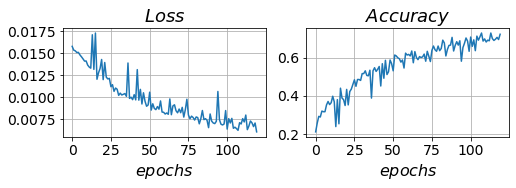

save_dir resnet18/pacs/SelfReg_official_test_HYPTEST/photo+art_painting+sketch(cartoon)/
device cuda:1
epoch: 0
Validation ==================================================
Avg acc (val): 0.1840
epoch: 1
Validation ==================================================
Avg acc (val): 0.2728
epoch: 2
Validation ==================================================
Avg acc (val): 0.2510
epoch: 3
Validation ==================================================
Avg acc (val): 0.3102
epoch: 4
Validation ==================================================
Avg acc (val): 0.3411
epoch: 5
Validation ==================================================
Avg acc (val): 0.3565
epoch: 6
Validation ==================================================
Avg acc (val): 0.3037
epoch: 7
Validation ==================================================
Avg acc (val): 0.3295
epoch: 8
Validation ==================================================
Avg acc (val): 0.4028
epoch: 9
Validation ========================================

epoch: 87
Validation ==================================================
Avg acc (val): 0.7104
epoch: 88
Validation ==================================================
Avg acc (val): 0.7323
epoch: 89
Validation ==================================================
Avg acc (val): 0.7555
epoch: 90
Validation ==================================================
Avg acc (val): 0.7439
epoch: 91
Validation ==================================================
Avg acc (val): 0.7387
epoch: 92
Validation ==================================================
Avg acc (val): 0.7413
epoch: 93
Validation ==================================================
Avg acc (val): 0.7593
epoch: 94
Validation ==================================================
Avg acc (val): 0.7310
epoch: 95
Validation ==================================================
Avg acc (val): 0.7529
epoch: 96
Validation ==================================================
Avg acc (val): 0.7683
epoch: 97
Validation =======================================

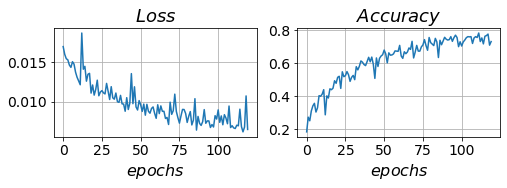

save_dir resnet18/pacs/SelfReg_official_test_HYPTEST/photo+cartoon+sketch(art_painting)/
device cuda:1
epoch: 0
Validation ==================================================
Avg acc (val): 0.1873
epoch: 1
Validation ==================================================
Avg acc (val): 0.2159
epoch: 2
Validation ==================================================
Avg acc (val): 0.2543
epoch: 3
Validation ==================================================
Avg acc (val): 0.3164
epoch: 4
Validation ==================================================
Avg acc (val): 0.2295
epoch: 5
Validation ==================================================
Avg acc (val): 0.3809
epoch: 6
Validation ==================================================
Avg acc (val): 0.4069
epoch: 7
Validation ==================================================
Avg acc (val): 0.3983
epoch: 8
Validation ==================================================
Avg acc (val): 0.3040
epoch: 9
Validation ========================================

epoch: 87
Validation ==================================================
Avg acc (val): 0.7990
epoch: 88
Validation ==================================================
Avg acc (val): 0.8052
epoch: 89
Validation ==================================================
Avg acc (val): 0.7816
epoch: 90
Validation ==================================================
Avg acc (val): 0.7494
epoch: 91
Validation ==================================================
Avg acc (val): 0.8052
epoch: 92
Validation ==================================================
Avg acc (val): 0.7928
epoch: 93
Validation ==================================================
Avg acc (val): 0.8139
epoch: 94
Validation ==================================================
Avg acc (val): 0.7903
epoch: 95
Validation ==================================================
Avg acc (val): 0.7816
epoch: 96
Validation ==================================================
Avg acc (val): 0.7730
epoch: 97
Validation =======================================

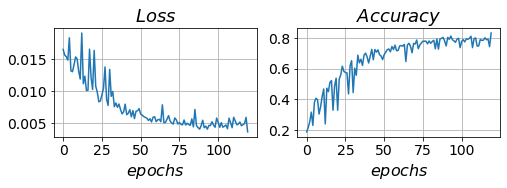

save_dir resnet18/pacs/SelfReg_official_test_HYPTEST/art_painting+cartoon+sketch(photo)/
device cuda:1
epoch: 0
Validation ==================================================
Avg acc (val): 0.1993
epoch: 1
Validation ==================================================
Avg acc (val): 0.2764
epoch: 2
Validation ==================================================
Avg acc (val): 0.2147
epoch: 3
Validation ==================================================
Avg acc (val): 0.2610
epoch: 4
Validation ==================================================
Avg acc (val): 0.2384
epoch: 5
Validation ==================================================
Avg acc (val): 0.3820
epoch: 6
Validation ==================================================
Avg acc (val): 0.2491
epoch: 7
Validation ==================================================
Avg acc (val): 0.3274
epoch: 8
Validation ==================================================
Avg acc (val): 0.2491
epoch: 9
Validation ========================================

epoch: 87
Validation ==================================================
Avg acc (val): 0.7117
epoch: 88
Validation ==================================================
Avg acc (val): 0.7497
epoch: 89
Validation ==================================================
Avg acc (val): 0.7367
epoch: 90
Validation ==================================================
Avg acc (val): 0.7450
epoch: 91
Validation ==================================================
Avg acc (val): 0.7473
epoch: 92
Validation ==================================================
Avg acc (val): 0.7544
epoch: 93
Validation ==================================================
Avg acc (val): 0.7556
epoch: 94
Validation ==================================================
Avg acc (val): 0.7628
epoch: 95
Validation ==================================================
Avg acc (val): 0.7141
epoch: 96
Validation ==================================================
Avg acc (val): 0.7461
epoch: 97
Validation =======================================

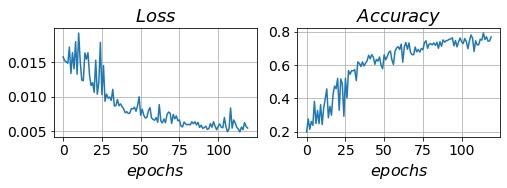

In [8]:
#is_selfreg = False
save_model_setting(model_settings, used_model, domains, dataset, save_name)
set_train = IDCL_setting if is_idcl else classic_setting
temp_dict = {
    "device": device,
    "epochs": epochs,
    "criterion": criterion,
    "is_selfreg": is_selfreg,
    "is_idcl": is_idcl,
}

paper_performance = [95.66,79.89,75.61,73.33]

for i in range(1, number_of_tests + 1):
    try_check = i

    for test_idx in [3, 2, 1, 0]:

        ##########################
        ####   Setting Train  ####
        ##########################

        model_sets = [
            test_idx,
            domains,
            batch_size,
            is_pretrained,
            train_tf,
            test_tf,
            used_model,
            pacs_ver,
            used_optimizer,
            is_hyp,
        ]
        train_settings, test_loader = set_train(*model_sets)
        train_settings.update(temp_dict)

        save_dir = save_route(test_idx, domains, dataset, save_name, used_model)
        print("save_dir", save_dir)

        try:
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)
        except:
            print("Error : Creating directory. " + save_dir)

        ##########################
        ####     Training     ####
        #####################p#####

        model, losses, accuracies = train(**train_settings)
        test_accuracy = test(
            device, model, criterion, test_loader, used_model, save_dir, try_check
        )
        print("Paper accuracy: ",paper_performance[test_idx])

        total_result_text_path = os.path.join(save_dir, "test_total_result.txt")
        with open(total_result_text_path, "a") as f:
            print(test_accuracy)
            f.write(str(test_accuracy) + "\n")

        plotting(losses, accuracies, used_model, save_dir, is_pretrained, try_check)
#         save_model(model, used_model, save_dir, is_pretrained, try_check)
        

In [9]:
##############################
# Training Setting
##############################

# Select model to train
# resnet18(pytorch official):'resnet18_classic'
# SelfReg : 'resnet18' 
used_model = 'resnet18'
save_name = 'SelfReg_official_test_EUCTEST'     # save_dir name
                                        # save_path : resnet_18/pacs/{save_name}/
dataset ='pacs'        
pacs_ver = '~/data/pacs_official_split' 
number_of_tests = 5
gpu_num = 1
n_workers = 6

##############################
# Basic Hyper-parameters
##############################

# is_selfreg = True  # use selfreg?
# is_idcl = True # use IDCL?
is_selfreg = False  # use selfreg?
is_idcl = False # use IDCL?

epochs = 100
batch_size = 128
is_pretrained = False  # Use ImageNet pretrain weight ?
used_optimizer = 'SGD' # 'Adam' or 'SGD'
is_hyp = False
#Learning rate
lr = 4e-3 
lr_decay_epoch = [100]
lr_decay_gamma = 0.1


train_tf, test_tf = get_tf(augment=True)



save_dir resnet18/pacs/SelfReg_official_test_EUCTEST/photo+art_painting+cartoon(sketch)/
device cuda:1
epoch: 0
Validation ==================================================
Avg acc (val): 0.2451
epoch: 1
Validation ==================================================
Avg acc (val): 0.3279
epoch: 2
Validation ==================================================
Avg acc (val): 0.3653
epoch: 3
Validation ==================================================
Avg acc (val): 0.3896
epoch: 4
Validation ==================================================
Avg acc (val): 0.3653
epoch: 5
Validation ==================================================
Avg acc (val): 0.3539
epoch: 6
Validation ==================================================
Avg acc (val): 0.3961
epoch: 7
Validation ==================================================
Avg acc (val): 0.4205
epoch: 8
Validation ==================================================
Avg acc (val): 0.4968
epoch: 9
Validation ========================================

epoch: 87
Validation ==================================================
Avg acc (val): 0.7159
epoch: 88
Validation ==================================================
Avg acc (val): 0.7305
epoch: 89
Validation ==================================================
Avg acc (val): 0.7468
epoch: 90
Validation ==================================================
Avg acc (val): 0.7208
epoch: 91
Validation ==================================================
Avg acc (val): 0.7370
epoch: 92
Validation ==================================================
Avg acc (val): 0.7208
epoch: 93
Validation ==================================================
Avg acc (val): 0.7711
epoch: 94
Validation ==================================================
Avg acc (val): 0.7500
epoch: 95
Validation ==================================================
Avg acc (val): 0.7419
epoch: 96
Validation ==================================================
Avg acc (val): 0.7597
epoch: 97
Validation =======================================

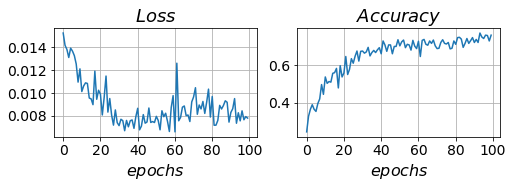

save_dir resnet18/pacs/SelfReg_official_test_EUCTEST/photo+art_painting+sketch(cartoon)/
device cuda:1
epoch: 0
Validation ==================================================
Avg acc (val): 0.1943
epoch: 1
Validation ==================================================
Avg acc (val): 0.4041
epoch: 2
Validation ==================================================
Avg acc (val): 0.3526
epoch: 3
Validation ==================================================
Avg acc (val): 0.4208
epoch: 4
Validation ==================================================
Avg acc (val): 0.3192
epoch: 5
Validation ==================================================
Avg acc (val): 0.5045
epoch: 6
Validation ==================================================
Avg acc (val): 0.4311
epoch: 7
Validation ==================================================
Avg acc (val): 0.4028
epoch: 8
Validation ==================================================
Avg acc (val): 0.5405
epoch: 9
Validation ========================================

epoch: 87
Validation ==================================================
Avg acc (val): 0.8044
epoch: 88
Validation ==================================================
Avg acc (val): 0.8134
epoch: 89
Validation ==================================================
Avg acc (val): 0.7876
epoch: 90
Validation ==================================================
Avg acc (val): 0.8147
epoch: 91
Validation ==================================================
Avg acc (val): 0.8031
epoch: 92
Validation ==================================================
Avg acc (val): 0.7902
epoch: 93
Validation ==================================================
Avg acc (val): 0.7606
epoch: 94
Validation ==================================================
Avg acc (val): 0.7413
epoch: 95
Validation ==================================================
Avg acc (val): 0.7915
epoch: 96
Validation ==================================================
Avg acc (val): 0.7658
epoch: 97
Validation =======================================

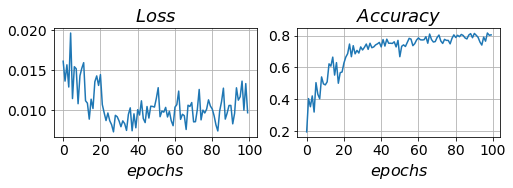

save_dir resnet18/pacs/SelfReg_official_test_EUCTEST/photo+cartoon+sketch(art_painting)/
device cuda:1
epoch: 0
Validation ==================================================
Avg acc (val): 0.2060
epoch: 1
Validation ==================================================
Avg acc (val): 0.2841
epoch: 2
Validation ==================================================
Avg acc (val): 0.4454
epoch: 3
Validation ==================================================
Avg acc (val): 0.3635
epoch: 4
Validation ==================================================
Avg acc (val): 0.3065
epoch: 5
Validation ==================================================
Avg acc (val): 0.4479
epoch: 6
Validation ==================================================
Avg acc (val): 0.3350
epoch: 7
Validation ==================================================
Avg acc (val): 0.6030
epoch: 8
Validation ==================================================
Avg acc (val): 0.5608
epoch: 9
Validation ========================================

epoch: 87
Validation ==================================================
Avg acc (val): 0.8734
epoch: 88
Validation ==================================================
Avg acc (val): 0.8524
epoch: 89
Validation ==================================================
Avg acc (val): 0.8548
epoch: 90
Validation ==================================================
Avg acc (val): 0.8226
epoch: 91
Validation ==================================================
Avg acc (val): 0.8573
epoch: 92
Validation ==================================================
Avg acc (val): 0.8424
epoch: 93
Validation ==================================================
Avg acc (val): 0.8387
epoch: 94
Validation ==================================================
Avg acc (val): 0.8375
epoch: 95
Validation ==================================================
Avg acc (val): 0.8337
epoch: 96
Validation ==================================================
Avg acc (val): 0.8400
epoch: 97
Validation =======================================

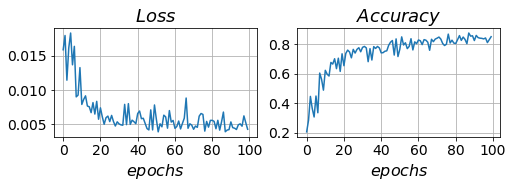

save_dir resnet18/pacs/SelfReg_official_test_EUCTEST/art_painting+cartoon+sketch(photo)/
device cuda:1
epoch: 0
Validation ==================================================
Avg acc (val): 0.1922
epoch: 1
Validation ==================================================
Avg acc (val): 0.3381
epoch: 2
Validation ==================================================
Avg acc (val): 0.3203
epoch: 3
Validation ==================================================
Avg acc (val): 0.3974
epoch: 4
Validation ==================================================
Avg acc (val): 0.4306
epoch: 5
Validation ==================================================
Avg acc (val): 0.4792
epoch: 6
Validation ==================================================
Avg acc (val): 0.4982
epoch: 7
Validation ==================================================
Avg acc (val): 0.5374
epoch: 8
Validation ==================================================
Avg acc (val): 0.5101
epoch: 9
Validation ========================================

epoch: 87
Validation ==================================================
Avg acc (val): 0.8221
epoch: 88
Validation ==================================================
Avg acc (val): 0.8304
epoch: 89
Validation ==================================================
Avg acc (val): 0.7663
epoch: 90
Validation ==================================================
Avg acc (val): 0.7663
epoch: 91
Validation ==================================================
Avg acc (val): 0.8090
epoch: 92
Validation ==================================================
Avg acc (val): 0.7900
epoch: 93
Validation ==================================================
Avg acc (val): 0.8066
epoch: 94
Validation ==================================================
Avg acc (val): 0.8221
epoch: 95
Validation ==================================================
Avg acc (val): 0.7544
epoch: 96
Validation ==================================================
Avg acc (val): 0.8221
epoch: 97
Validation =======================================

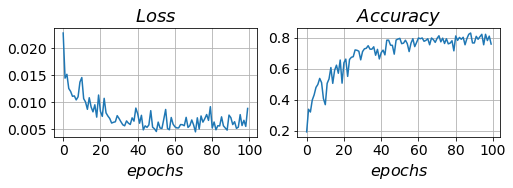

save_dir resnet18/pacs/SelfReg_official_test_EUCTEST/photo+art_painting+cartoon(sketch)/
device cuda:1
epoch: 0
Validation ==================================================
Avg acc (val): 0.2581
epoch: 1
Validation ==================================================
Avg acc (val): 0.3231
epoch: 2
Validation ==================================================
Avg acc (val): 0.3198
epoch: 3
Validation ==================================================
Avg acc (val): 0.3295
epoch: 4
Validation ==================================================
Avg acc (val): 0.3831
epoch: 5
Validation ==================================================
Avg acc (val): 0.3977
epoch: 6
Validation ==================================================
Avg acc (val): 0.4286
epoch: 7
Validation ==================================================
Avg acc (val): 0.4675
epoch: 8
Validation ==================================================
Avg acc (val): 0.4675
epoch: 9
Validation ========================================

epoch: 87
Validation ==================================================
Avg acc (val): 0.7370
epoch: 88
Validation ==================================================
Avg acc (val): 0.7175
epoch: 89
Validation ==================================================
Avg acc (val): 0.7516
epoch: 90
Validation ==================================================
Avg acc (val): 0.7338
epoch: 91
Validation ==================================================
Avg acc (val): 0.7873
epoch: 92
Validation ==================================================
Avg acc (val): 0.7614
epoch: 93
Validation ==================================================
Avg acc (val): 0.7727
epoch: 94
Validation ==================================================
Avg acc (val): 0.7451
epoch: 95
Validation ==================================================
Avg acc (val): 0.7338
epoch: 96
Validation ==================================================
Avg acc (val): 0.7419
epoch: 97
Validation =======================================

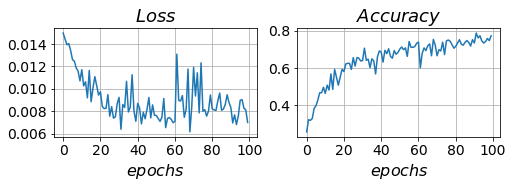

save_dir resnet18/pacs/SelfReg_official_test_EUCTEST/photo+art_painting+sketch(cartoon)/
device cuda:1
epoch: 0
Validation ==================================================
Avg acc (val): 0.1853
epoch: 1
Validation ==================================================
Avg acc (val): 0.2870
epoch: 2
Validation ==================================================
Avg acc (val): 0.4234
epoch: 3
Validation ==================================================
Avg acc (val): 0.3977
epoch: 4
Validation ==================================================
Avg acc (val): 0.3771
epoch: 5
Validation ==================================================
Avg acc (val): 0.3938
epoch: 6
Validation ==================================================
Avg acc (val): 0.5354
epoch: 7
Validation ==================================================
Avg acc (val): 0.5032
epoch: 8
Validation ==================================================
Avg acc (val): 0.5830
epoch: 9
Validation ========================================

epoch: 87
Validation ==================================================
Avg acc (val): 0.8198
epoch: 88
Validation ==================================================
Avg acc (val): 0.8250
epoch: 89
Validation ==================================================
Avg acc (val): 0.8121
epoch: 90
Validation ==================================================
Avg acc (val): 0.8044
epoch: 91
Validation ==================================================
Avg acc (val): 0.8185
epoch: 92
Validation ==================================================
Avg acc (val): 0.8095
epoch: 93
Validation ==================================================
Avg acc (val): 0.8391
epoch: 94
Validation ==================================================
Avg acc (val): 0.8044
epoch: 95
Validation ==================================================
Avg acc (val): 0.8198
epoch: 96
Validation ==================================================
Avg acc (val): 0.7902
epoch: 97
Validation =======================================

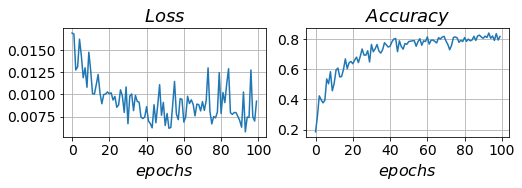

save_dir resnet18/pacs/SelfReg_official_test_EUCTEST/photo+cartoon+sketch(art_painting)/
device cuda:1
epoch: 0
Validation ==================================================
Avg acc (val): 0.2618
epoch: 1
Validation ==================================================
Avg acc (val): 0.2419
epoch: 2
Validation ==================================================
Avg acc (val): 0.4094
epoch: 3
Validation ==================================================
Avg acc (val): 0.3300
epoch: 4
Validation ==================================================
Avg acc (val): 0.4814
epoch: 5
Validation ==================================================
Avg acc (val): 0.4826
epoch: 6
Validation ==================================================
Avg acc (val): 0.4615
epoch: 7
Validation ==================================================
Avg acc (val): 0.4950
epoch: 8
Validation ==================================================
Avg acc (val): 0.6166
epoch: 9
Validation ========================================

epoch: 87
Validation ==================================================
Avg acc (val): 0.8375
epoch: 88
Validation ==================================================
Avg acc (val): 0.8275
epoch: 89
Validation ==================================================
Avg acc (val): 0.7568
epoch: 90
Validation ==================================================
Avg acc (val): 0.8362
epoch: 91
Validation ==================================================
Avg acc (val): 0.8548
epoch: 92
Validation ==================================================
Avg acc (val): 0.8548
epoch: 93
Validation ==================================================
Avg acc (val): 0.8400
epoch: 94
Validation ==================================================
Avg acc (val): 0.8151
epoch: 95
Validation ==================================================
Avg acc (val): 0.8524
epoch: 96
Validation ==================================================
Avg acc (val): 0.8548
epoch: 97
Validation =======================================

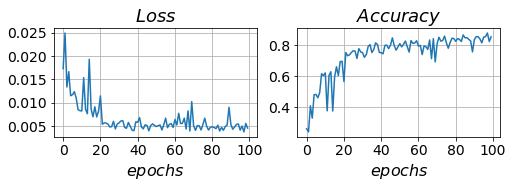

save_dir resnet18/pacs/SelfReg_official_test_EUCTEST/art_painting+cartoon+sketch(photo)/
device cuda:1
epoch: 0
Validation ==================================================
Avg acc (val): 0.1910
epoch: 1
Validation ==================================================
Avg acc (val): 0.3298
epoch: 2
Validation ==================================================
Avg acc (val): 0.4342
epoch: 3
Validation ==================================================
Avg acc (val): 0.4377
epoch: 4
Validation ==================================================
Avg acc (val): 0.4614
epoch: 5
Validation ==================================================
Avg acc (val): 0.4152
epoch: 6
Validation ==================================================
Avg acc (val): 0.5314
epoch: 7
Validation ==================================================
Avg acc (val): 0.5445
epoch: 8
Validation ==================================================
Avg acc (val): 0.4555
epoch: 9
Validation ========================================

epoch: 87
Validation ==================================================
Avg acc (val): 0.7960
epoch: 88
Validation ==================================================
Avg acc (val): 0.7746
epoch: 89
Validation ==================================================
Avg acc (val): 0.7616
epoch: 90
Validation ==================================================
Avg acc (val): 0.8066
epoch: 91
Validation ==================================================
Avg acc (val): 0.8078
epoch: 92
Validation ==================================================
Avg acc (val): 0.7722
epoch: 93
Validation ==================================================
Avg acc (val): 0.8078
epoch: 94
Validation ==================================================
Avg acc (val): 0.7877
epoch: 95
Validation ==================================================
Avg acc (val): 0.8090
epoch: 96
Validation ==================================================
Avg acc (val): 0.8256
epoch: 97
Validation =======================================

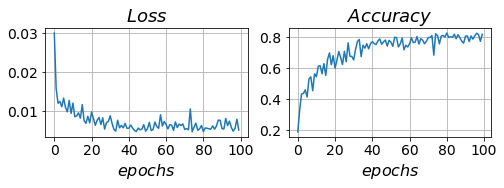

save_dir resnet18/pacs/SelfReg_official_test_EUCTEST/photo+art_painting+cartoon(sketch)/
device cuda:1
epoch: 0
Validation ==================================================
Avg acc (val): 0.2338
epoch: 1
Validation ==================================================
Avg acc (val): 0.3442
epoch: 2
Validation ==================================================
Avg acc (val): 0.2435
epoch: 3
Validation ==================================================
Avg acc (val): 0.3604
epoch: 4
Validation ==================================================
Avg acc (val): 0.4205
epoch: 5
Validation ==================================================
Avg acc (val): 0.4091
epoch: 6
Validation ==================================================
Avg acc (val): 0.4221
epoch: 7
Validation ==================================================
Avg acc (val): 0.4643
epoch: 8
Validation ==================================================
Avg acc (val): 0.4562
epoch: 9
Validation ========================================

epoch: 87
Validation ==================================================
Avg acc (val): 0.7419
epoch: 88
Validation ==================================================
Avg acc (val): 0.7581
epoch: 89
Validation ==================================================
Avg acc (val): 0.7711
epoch: 90
Validation ==================================================
Avg acc (val): 0.6899
epoch: 91
Validation ==================================================
Avg acc (val): 0.7256
epoch: 92
Validation ==================================================
Avg acc (val): 0.7727
epoch: 93
Validation ==================================================
Avg acc (val): 0.7565
epoch: 94
Validation ==================================================
Avg acc (val): 0.7808
epoch: 95
Validation ==================================================
Avg acc (val): 0.7354
epoch: 96
Validation ==================================================
Avg acc (val): 0.7273
epoch: 97
Validation =======================================

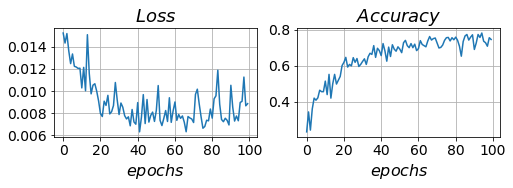

save_dir resnet18/pacs/SelfReg_official_test_EUCTEST/photo+art_painting+sketch(cartoon)/
device cuda:1
epoch: 0
Validation ==================================================
Avg acc (val): 0.2600
epoch: 1
Validation ==================================================
Avg acc (val): 0.2806
epoch: 2
Validation ==================================================
Avg acc (val): 0.4015
epoch: 3
Validation ==================================================
Avg acc (val): 0.4633
epoch: 4
Validation ==================================================
Avg acc (val): 0.3771
epoch: 5
Validation ==================================================
Avg acc (val): 0.4324
epoch: 6
Validation ==================================================
Avg acc (val): 0.4080
epoch: 7
Validation ==================================================
Avg acc (val): 0.5212
epoch: 8
Validation ==================================================
Avg acc (val): 0.5032
epoch: 9
Validation ========================================

epoch: 87
Validation ==================================================
Avg acc (val): 0.7786
epoch: 88
Validation ==================================================
Avg acc (val): 0.8327
epoch: 89
Validation ==================================================
Avg acc (val): 0.8005
epoch: 90
Validation ==================================================
Avg acc (val): 0.7838
epoch: 91
Validation ==================================================
Avg acc (val): 0.7928
epoch: 92
Validation ==================================================
Avg acc (val): 0.7967
epoch: 93
Validation ==================================================
Avg acc (val): 0.8340
epoch: 94
Validation ==================================================
Avg acc (val): 0.7954
epoch: 95
Validation ==================================================
Avg acc (val): 0.8172
epoch: 96
Validation ==================================================
Avg acc (val): 0.8005
epoch: 97
Validation =======================================

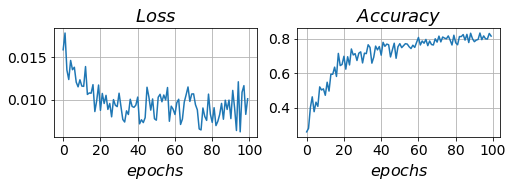

save_dir resnet18/pacs/SelfReg_official_test_EUCTEST/photo+cartoon+sketch(art_painting)/
device cuda:1
epoch: 0
Validation ==================================================
Avg acc (val): 0.3127
epoch: 1
Validation ==================================================
Avg acc (val): 0.3350
epoch: 2
Validation ==================================================
Avg acc (val): 0.4107
epoch: 3
Validation ==================================================
Avg acc (val): 0.4578
epoch: 4
Validation ==================================================
Avg acc (val): 0.3089
epoch: 5
Validation ==================================================
Avg acc (val): 0.4839
epoch: 6
Validation ==================================================
Avg acc (val): 0.5744
epoch: 7
Validation ==================================================
Avg acc (val): 0.5918
epoch: 8
Validation ==================================================
Avg acc (val): 0.6365
epoch: 9
Validation ========================================

epoch: 87
Validation ==================================================
Avg acc (val): 0.8127
epoch: 88
Validation ==================================================
Avg acc (val): 0.8437
epoch: 89
Validation ==================================================
Avg acc (val): 0.8548
epoch: 90
Validation ==================================================
Avg acc (val): 0.8400
epoch: 91
Validation ==================================================
Avg acc (val): 0.8375
epoch: 92
Validation ==================================================
Avg acc (val): 0.7940
epoch: 93
Validation ==================================================
Avg acc (val): 0.8486
epoch: 94
Validation ==================================================
Avg acc (val): 0.8337
epoch: 95
Validation ==================================================
Avg acc (val): 0.8400
epoch: 96
Validation ==================================================
Avg acc (val): 0.8598
epoch: 97
Validation =======================================

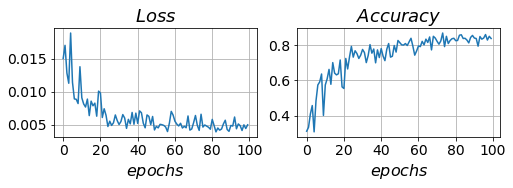

save_dir resnet18/pacs/SelfReg_official_test_EUCTEST/art_painting+cartoon+sketch(photo)/
device cuda:1
epoch: 0
Validation ==================================================
Avg acc (val): 0.2123
epoch: 1
Validation ==================================================
Avg acc (val): 0.3665
epoch: 2
Validation ==================================================
Avg acc (val): 0.4152
epoch: 3
Validation ==================================================
Avg acc (val): 0.4425
epoch: 4
Validation ==================================================
Avg acc (val): 0.4330
epoch: 5
Validation ==================================================
Avg acc (val): 0.3749
epoch: 6
Validation ==================================================
Avg acc (val): 0.4057
epoch: 7
Validation ==================================================
Avg acc (val): 0.5314
epoch: 8
Validation ==================================================
Avg acc (val): 0.5599
epoch: 9
Validation ========================================

KeyboardInterrupt: 

In [10]:
#is_selfreg = False
save_model_setting(model_settings, used_model, domains, dataset, save_name)
set_train = IDCL_setting if is_idcl else classic_setting
temp_dict = {
    "device": device,
    "epochs": epochs,
    "criterion": criterion,
    "is_selfreg": is_selfreg,
    "is_idcl": is_idcl,
}

paper_performance = [95.66,79.89,75.61,73.33]

for i in range(1, number_of_tests + 1):
    try_check = i

    for test_idx in [3, 2, 1, 0]:

        ##########################
        ####   Setting Train  ####
        ##########################

        model_sets = [
            test_idx,
            domains,
            batch_size,
            is_pretrained,
            train_tf,
            test_tf,
            used_model,
            pacs_ver,
            used_optimizer,
            is_hyp,
        ]
        train_settings, test_loader = set_train(*model_sets)
        train_settings.update(temp_dict)

        save_dir = save_route(test_idx, domains, dataset, save_name, used_model)
        print("save_dir", save_dir)

        try:
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)
        except:
            print("Error : Creating directory. " + save_dir)

        ##########################
        ####     Training     ####
        #####################p#####

        model, losses, accuracies = train(**train_settings)
        test_accuracy = test(
            device, model, criterion, test_loader, used_model, save_dir, try_check
        )
        print("Paper accuracy: ",paper_performance[test_idx])

        total_result_text_path = os.path.join(save_dir, "test_total_result.txt")
        with open(total_result_text_path, "a") as f:
            print(test_accuracy)
            f.write(str(test_accuracy) + "\n")

        plotting(losses, accuracies, used_model, save_dir, is_pretrained, try_check)
#         save_model(model, used_model, save_dir, is_pretrained, try_check)
        